In [ ]:
%matplotlib inline

from pathlib import Path

from spectral_cube import SpectralCube, Projection
from astropy.io import fits

# from cube_analysis.profiles import radial_profile, surfdens_radial_profile

from astropy.visualization import simple_norm
from astropy.visualization.wcsaxes import add_beam, add_scalebar



In [ ]:
import seaborn as sb

sb.set("paper", font_scale=1.25,
       palette='colorblind',
       style='ticks',
       rc={'text.usetex': False})

In [ ]:
from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

In [ ]:
from matplotlib import cm
import matplotlib
from matplotlib.colors import ListedColormap

def half_table(table1_name, table2_name,
               reverse1=False, reverse2=False,
               pivot=0.5,
               cmap1_min=0,
               cmap1_max=1,
               cmap2_min=0,
               cmap2_max=1,
              ):
    """
    Splice together two matplotlib color tables.
    """

    n_col = 256
    # cmap1 = matplotlib.colormaps.get_cmap(table1_name, n_col)
    # cmap2 = matplotlib.colormaps.get_cmap(table2_name, n_col)
    cmap1 = cm.get_cmap(table1_name, n_col)
    cmap2 = cm.get_cmap(table2_name, n_col)

    pivot_int = int(round(pivot*n_col))
    if pivot_int < 0:
        pivot_int = 0
    if pivot_int > 255:
        pivot_int = 255
    n_cmap1 = pivot_int
    n_cmap2 = n_col-pivot_int

    # initialize
    newcolors = cmap1(np.linspace(0,1,n_col))

    # now hack
    newcolors[:pivot_int,:] = cmap1(np.linspace(cmap1_min, cmap1_max, n_cmap1))
    newcolors[pivot_int:,:] = cmap2(np.linspace(cmap2_min, cmap2_max, n_cmap2))
    newcmp = ListedColormap(newcolors)

    return(newcmp)

# def noise_and_heat(pivot=0.2):
#     return(half_table('Greys', 'hot', pivot=pivot))

def noise_and_heat(pivot=0.2, **kwargs):
    return half_table('Greys', 'hot', pivot=pivot, **kwargs)

In [ ]:
# Load in galaxy parames
%run hi_galaxy_params.py

In [ ]:
# data_path = Path("/reduction10/erickoch/LGLBS/line_imaging/derived/")
data_path = Path("/reduction/erickoch/LGLBS/line_imaging/derived/")

these_targets = ['ngc6822', 'ic10', 'ic1613', 'wlm',] # 'm33']

gal_objs = {}
gal_objs['ngc6822'] = gal_ngc6822
gal_objs['ic10'] = gal_ic10
gal_objs['ic1613'] = gal_ic1613
gal_objs['wlm'] = gal_wlm
# gal_objs['m33'] = gal_m33



In [ ]:
gal_objs

In [ ]:
# Load the moment0 maps:

# Common physical resolution
this_scale = "120pc"

# Velocity resolution
# this_line = 'hi21cm_0p8kms'
this_line = 'himidres'
# this_line = 'hilores'

mom0_dict = {}
emom0_dict = {}

tpeak_dict = {}
ew_dict = {}
mom2_dict = {}
mom1_dict = {}

mom0_native_dict = {}
tpeak_native_dict = {}

for this_gal in these_targets:

    mom0_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_C+D+tp_{this_line}_{this_scale}_broad_mom0.fits"))
    emom0_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_C+D+tp_{this_line}_{this_scale}_broad_emom0.fits"))


    tpeak_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_C+D+tp_{this_line}_{this_scale}_broad_tpeak.fits"))
    ew_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_C+D+tp_{this_line}_{this_scale}_strict_ew.fits"))
    mom2_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_C+D+tp_{this_line}_{this_scale}_strict_mom2.fits"))

    mom1_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_C+D+tp_{this_line}_{this_scale}_strict_mom1.fits"))

    mom0_native_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_C+D+tp_{this_line}_broad_mom0.fits"))
    tpeak_native_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_C+D+tp_{this_line}_broad_tpeak.fits"))


In [ ]:
# Masses from the fixed resolution broad moment0 maps:

from astropy.wcs.utils import proj_plane_pixel_area

alpha_atom = 0.0196 * (u.M_sun / u.pc ** 2) / (u.K * u.km / u.s)
alpha_HI = ((1.82e18 * u.cm**-2) * c.m_p).to(u.solMass / u.pc**2) / (u.K * u.km / u.s)

hi_masses = {}

for this_gal in these_targets:
    total_intint = np.nansum(mom0_dict[this_gal])
    total_intint_err = np.nansum(emom0_dict[this_gal])

    # print(mom0_dict[this_gal].beam.major.to(u.arcsec),
    #       (np.sqrt(proj_plane_pixel_area(mom0_dict[this_gal].wcs.celestial)) * u.deg).to(u.arcsec))

    pixarea = (proj_plane_pixel_area(mom0_dict[this_gal].wcs.celestial)) * u.deg**2
    physarea = pixarea.to(u.sr).value * gal_objs[this_gal].distance.to(u.pc)**2

    pixperbeam = (mom0_dict[this_gal].beam.sr / pixarea).to(u.one)

    # print(pixarea, physarea, pixperbeam)

    # to surfdens
    atomic_gas_mass = alpha_HI * total_intint * physarea
    atomic_gas_mass_err = alpha_HI * total_intint_err * physarea / np.sqrt(pixperbeam)

    print(this_gal, np.log10(atomic_gas_mass.value), np.log10(atomic_gas_mass_err.value))
    print(this_gal, atomic_gas_mass, atomic_gas_mass_err)

    hi_masses[this_gal] = [atomic_gas_mass, atomic_gas_mass_err]


In [ ]:
alpha_HI

### Literature mass values for comparison

In [ ]:
# NGC6822:

# de Blok & Walter 2006a
# https://ui.adsabs.harvard.edu/abs/2006AJ....131..343D/abstract
# Single dish!
mhi_dB06 = 1.34e8 * u.solMass * (520 / 490)**2 # distance correction for 520 kpc

# Namumba+17
# https://ui.adsabs.harvard.edu/abs/2017MNRAS.472.3761N/abstract
mhi_N17 = 1.3e8 * u.solMass  * (520 / 480)**2 # distance correction for 520 kpc

print(mhi_dB06, mhi_N17)

In [ ]:
hi_masses['ngc6822']

In [ ]:
100 * (hi_masses['ngc6822'][0] - mhi_N17) / mhi_N17

In [ ]:
# IC10:

# LITTLE THINGS (Hunter+12)
mhi_h12_ic10 = 10**7.78 * u.solMass
mhi_h12_ic10

# Nidever+13 wider scale GBT map:
# https://ui.adsabs.harvard.edu/abs/2013ApJ...779L..15N/abstract
mhi_n13_ic10 = 9.5e7 * (700 / 805)**2  * u.solMass

mhi_n13_ic10

# Namumba+19 with DRAO-ST
mhi_n19_ic10 = 7.8e7 * u.solMass



In [ ]:
hi_masses['ic10']

In [ ]:
100 * (hi_masses['ic10'][0] - mhi_h12_ic10) / mhi_h12_ic10


In [ ]:
100 * (hi_masses['ic10'][0] - mhi_n13_ic10) / mhi_n13_ic10


In [ ]:
100 * (hi_masses['ic10'][0] - mhi_n19_ic10) / mhi_n19_ic10


In [ ]:
# IC1613:

# LITTLE THINGS (Hunter+12)
mhi_h12_ic1613 = 10**7.53 * u.solMass
mhi_h12_ic1613

mhi_h12_ic1613


In [ ]:
hi_masses['ic1613']

In [ ]:
100 * (hi_masses['ic1613'][0] - mhi_h12_ic1613) / mhi_h12_ic1613

# Difference likely due to inclusion of the single-dish data here.

In [ ]:
# WLM

# LITTLE THINGS (Hunter+12)
mhi_h12_wlm = 10**7.86 * u.solMass
mhi_h12_wlm

# Kepley+07
mhi_k07_wlm = 6.3e7 * u.solMass * (gal_wlm.distance / (0.95 * u.Mpc))**2

# Hunter+13 GBT
mhi_h13_wlm = 1.1e8 * u.solMass

In [ ]:
hi_masses['wlm']


In [ ]:
100 * (hi_masses['wlm'][0] - mhi_h12_wlm) / mhi_h12_wlm


In [ ]:
100 * (hi_masses['wlm'][0] - mhi_k07_wlm) / mhi_k07_wlm


In [ ]:
100 * (hi_masses['wlm'][0] - mhi_h13_wlm) / mhi_h13_wlm


### Moment map figures

In [ ]:

# fig = plt.figure(figsize=(8.4, (4.4 / 6.4) * 8.4), layout='constrained')
fig = plt.figure(figsize=(8.4, 8.4), layout='constrained')

axs = []

for ii, this_gal in enumerate(these_targets):

    ax = fig.add_subplot(2, 2, ii+1, projection=tpeak_dict[this_gal].wcs)

    norm = simple_norm(mom0_native_dict[this_gal].value,
                       stretch='asinh',
                       min_cut=0,
                       max_cut=50/0.0196)
                       # max_cut=40/0.0196)

    im = ax.imshow(mom0_native_dict[this_gal].value,
                   origin='lower',
                   norm=norm,
                   cmap=noise_and_heat(cmap2_max=0.9))

    # plt.colorbar()
    # cbar = fig.colorbar(im, ax=ax, shrink=1.0)
    # cbar.set_label("Integrated Intensity (K km/s)")

    # radii = gal_objs[this_gal].radius(header=mom0_dict[this_gal].header).to(u.kpc)

    # if this_gal == "wlm":
    #     # Make a bit larger to avoid overlap with the galaxy
    #     this_rad = 7
    # else:
    #     this_rad = 5

    # cs = ax.contour(radii.value, levels=[this_rad], colors='#0C7BDC')
    # # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc", colors='white')
    # # for l in labels:
    # #     l.set_fontweight('bold')
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc")
    # for l in labels:
    #     l.set_fontweight('bold')

    # Show extent of the maps
    cs = ax.contour(np.isfinite(tpeak_native_dict[this_gal].value), colors='gray', levels=[0.5],
                   alpha=0.25, linewidths=3)
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"Mosaic extent")
    # for l in labels:
    #     l.set_fontweight('bold')


    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_axislabel('RA (ICRS)', minpad=0.45)
    lat.set_axislabel('Declination (ICRS)', minpad=0.35)

    ax.text(0.025, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='left', va='top')

    add_beam(ax,
             major=mom0_native_dict[this_gal].beam.major,
             minor=mom0_native_dict[this_gal].beam.minor,
             angle=mom0_native_dict[this_gal].beam.pa,
             frame=True, facecolor='k', edgecolor='k',
             zorder=-1, corner='bottom left')

    kpc_ang = (((1 * u.kpc) / gal_objs[this_gal].distance).to(u.one) * u.rad).to(u.arcsec)
    print(kpc_ang)
    add_scalebar(ax, kpc_ang, corner='bottom right', label='1 kpc',
                 frame=False, width=3)

    axs.append(ax)

cbar = fig.colorbar(im, ax=axs, shrink=1.0, location='top', ticklocation='bottom')
cbar.set_label("Integrated Intensity (K km/s)")
cbar.ax.tick_params(labelsize=10, rotation=45)

# plt.tight_layout()

# fig.savefig("../figures/dwarfs_c+d_moment0.pdf", bbox_inches='tight')

In [ ]:

# fig = plt.figure(figsize=(8.4, (4.4 / 6.4) * 8.4), layout='constrained')
fig = plt.figure(figsize=(8.4, 8.4), layout='constrained')

axs = []

for ii, this_gal in enumerate(these_targets):

    if this_gal == "m33" or this_gal == "m31":
        continue

    ax = fig.add_subplot(2, 2, ii+1, projection=tpeak_dict[this_gal].wcs)

    ax.set_axis_off()

    norm = simple_norm(mom0_native_dict[this_gal].value,
                       stretch='asinh',
                       min_cut=0,
                       max_cut=50/0.0196)
                       # max_cut=40/0.0196)

    im = ax.imshow(mom0_native_dict[this_gal].value,
                   origin='lower',
                   norm=norm,
                   cmap=noise_and_heat(cmap2_max=0.9))

    # Show extent of the maps
    cs = ax.contour(nd.binary_erosion(np.isfinite(tpeak_native_dict[this_gal].value), iterations=8),
                    colors='gray', levels=[0.0],
                   alpha=0.25, linewidths=3)
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"Mosaic extent")
    # for l in labels:
    #     l.set_fontweight('bold')


    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_axislabel('RA (ICRS)', minpad=0.45)
    lat.set_axislabel('Declination (ICRS)', minpad=0.35)

    ax.text(0.025, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='left', va='top')

    # add_beam(ax,
    #          major=mom0_native_dict[this_gal].beam.major,
    #          minor=mom0_native_dict[this_gal].beam.minor,
    #          angle=mom0_native_dict[this_gal].beam.pa,
    #          frame=True, facecolor='k', edgecolor='k',
    #          zorder=-1, corner='bottom left')

    kpc_ang = (((1 * u.kpc) / gal_objs[this_gal].distance).to(u.one) * u.rad).to(u.arcsec)
    print(kpc_ang)
    add_scalebar(ax, kpc_ang, corner='bottom right', label='1 kpc',
                 frame=False, width=3)

    axs.append(ax)

cbar = fig.colorbar(im, ax=axs, shrink=1.0, location='top', ticklocation='bottom')
cbar.set_label("Integrated Intensity (K km/s)")
cbar.ax.tick_params(labelsize=10, rotation=45)

# plt.tight_layout()

fig.savefig("../figures/dwarfs_c+d_moment0.pdf", bbox_inches='tight')

In [ ]:

# fig = plt.figure(figsize=(8.4, (4.4 / 6.4) * 8.4), layout='constrained')
fig = plt.figure(figsize=(8.4, 8.4), layout='constrained')

axs = []

for ii, this_gal in enumerate(these_targets):

    if this_gal == "m33" or this_gal == "m31":
        continue

    ax = fig.add_subplot(2, 2, ii+1, projection=tpeak_dict[this_gal].wcs)

    ax.set_axis_off()

    norm = simple_norm(tpeak_native_dict[this_gal].value, stretch='asinh', min_cut=0, max_cut=150)
    # plt.imshow(mom0_dict[this_gal].value, origin='lower', norm=norm, cmap=noise_and_heat())

    im = ax.imshow(tpeak_native_dict[this_gal].value, origin='lower', norm=norm,
                   cmap=noise_and_heat(cmap2_max=0.9))
    # plt.colorbar()
    # cbar = fig.colorbar(im, ax=ax, shrink=1.0)
    # cbar.set_label("Integrated Intensity (K km/s)")

    # radii = gal_objs[this_gal].radius(header=mom0_dict[this_gal].header).to(u.kpc)

    # if this_gal == "wlm":
    #     # Make a bit larger to avoid overlap with the galaxy
    #     this_rad = 7
    # else:
    #     this_rad = 5

    # cs = ax.contour(radii.value, levels=[this_rad], colors='white')
    # # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc", colors='white')
    # # for l in labels:
    # #     l.set_fontweight('bold')
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc")
    # for l in labels:
    #     l.set_fontweight('bold')

    # Show extent of the maps
    # cs = ax.contour(np.isfinite(tpeak_native_dict[this_gal].value), colors='gray', levels=[0.5],
    #                alpha=0.25, linewidths=3)
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"Mosaic extent")
    # for l in labels:
    #     l.set_fontweight('bold')


    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_axislabel('RA (ICRS)', minpad=0.45)
    lat.set_axislabel('Declination (ICRS)', minpad=0.35)

    ax.text(0.025, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='left', va='top')

    # add_beam(ax,
    #          major=mom0_native_dict[this_gal].beam.major,
    #          minor=mom0_native_dict[this_gal].beam.minor,
    #          angle=mom0_native_dict[this_gal].beam.pa,
    #          frame=True, facecolor='k', edgecolor='k',
    #          zorder=-1, corner='bottom left')

    kpc_ang = (((1 * u.kpc) / gal_objs[this_gal].distance).to(u.one) * u.rad).to(u.arcsec)
    print(kpc_ang)
    add_scalebar(ax, kpc_ang, corner='bottom right', label='1 kpc',
                 frame=False, width=3)

    axs.append(ax)

cbar = fig.colorbar(im, ax=axs, shrink=1.0, location='top', ticklocation='bottom')
cbar.set_label("Peak Temperature (K)")
cbar.ax.tick_params(labelsize=10, rotation=45)

# plt.tight_layout()

fig.savefig("../figures/dwarfs_c+d_tpeak.pdf", bbox_inches='tight')

In [ ]:

# fig = plt.figure(figsize=(8.4, (4.4 / 6.4) * 8.4), layout='constrained')
fig = plt.figure(figsize=(8.4, 8.4), layout='constrained')

axs = []

for ii, this_gal in enumerate(these_targets):

    if this_gal == "m33" or this_gal == "m31":
        continue

    if this_gal != "ngc6822":
        cent_y = ew_dict[this_gal].shape[0] // 2
        cent_x = ew_dict[this_gal].shape[1] // 2
        if this_gal == 'wlm':
            box_size = 200
        else:
            box_size = 300
        this_slice = (slice(cent_y-box_size, cent_y+box_size+1),
                     slice(cent_x-box_size, cent_x+box_size+1))
    else:
        this_slice = (slice(None), slice(None))

    print(this_gal, this_slice)

    ax = fig.add_subplot(2, 2, ii+1, projection=tpeak_dict[this_gal][this_slice].wcs)

    ax.set_axis_off()

    norm = simple_norm(ew_dict[this_gal].value, stretch='linear', min_cut=0, max_cut=15)
    # plt.imshow(mom0_dict[this_gal].value, origin='lower', norm=norm, cmap=noise_and_heat())

    im = ax.imshow(ew_dict[this_gal][this_slice].value, origin='lower', norm=norm, cmap='cividis')
                   # cmap=noise_and_heat())

    print(ew_dict[this_gal].shape)
    # plt.colorbar()
    # cbar = fig.colorbar(im, ax=ax, shrink=1.0)
    # cbar.set_label("Integrated Intensity (K km/s)")


    # radii = gal_objs[this_gal].radius(header=mom0_dict[this_gal].header).to(u.kpc)

    # if this_gal == "wlm":
    #     # Make a bit larger to avoid overlap with the galaxy
    #     this_rad = 7
    # else:
    #     this_rad = 5

    # cs = ax.contour(radii.value, levels=[this_rad], colors='#0C7BDC')
    # # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc", colors='white')
    # # for l in labels:
    # #     l.set_fontweight('bold')
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc")
    # for l in labels:
    #     l.set_fontweight('bold')

    # Show extent of the maps
    # cs = ax.contour(np.isfinite(mom0_native_dict[this_gal].value), colors='gray', levels=[0.5],
    #                alpha=0.25, linewidths=3)
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"Mosaic extent")
    # for l in labels:
    #     l.set_fontweight('bold')


    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_axislabel('RA (ICRS)', minpad=0.45)
    lat.set_axislabel('Declination (ICRS)', minpad=0.35)

    ax.text(0.025, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='left', va='top')

    # add_beam(ax,
    #          major=ew_dict[this_gal].beam.major,
    #          minor=ew_dict[this_gal].beam.minor,
    #          angle=ew_dict[this_gal].beam.pa,
    #          frame=True, facecolor='k', edgecolor='k',
    #          zorder=-1, corner='bottom left')

    kpc_ang = (((1 * u.kpc) / gal_objs[this_gal].distance).to(u.one) * u.rad).to(u.arcsec)
    print(kpc_ang)
    add_scalebar(ax, kpc_ang, corner='bottom right', label='1 kpc',
                 frame=False, width=3)

    axs.append(ax)

cbar = fig.colorbar(im, ax=axs, shrink=1.0, location='top', ticklocation='bottom')
cbar.set_label("Line Width (km/s)")
cbar.ax.tick_params(labelsize=10, rotation=45)

# plt.tight_layout()

fig.savefig("../figures/dwarfs_c+d_ew.pdf", bbox_inches='tight')

In [ ]:

# fig = plt.figure(figsize=(8.4, (4.4 / 6.4) * 8.4), layout='constrained')
fig = plt.figure(figsize=(8.4, 8.4), layout='constrained')

axs = []

rot_vel = {'ngc6822': 60, 'ic10': 36*1.5, 'ic1613': 17, 'wlm': 37}

for ii, this_gal in enumerate(these_targets):

    if this_gal == "m33" or this_gal == "m31":
        continue

    if this_gal != "ngc6822":
        cent_y = ew_dict[this_gal].shape[0] // 2
        cent_x = ew_dict[this_gal].shape[1] // 2
        if this_gal == 'wlm':
            box_size = 200
        else:
            box_size = 300
        this_slice = (slice(cent_y-box_size, cent_y+box_size+1),
                     slice(cent_x-box_size, cent_x+box_size+1))
    else:
        this_slice = (slice(None), slice(None))

    print(this_gal, this_slice)

    ax = fig.add_subplot(2, 2, ii+1, projection=tpeak_dict[this_gal][this_slice].wcs)

    ax.set_axis_off()

    # norm = simple_norm(mom1_dict[this_gal].value, stretch='linear', min_cut=0, max_cut=15)
    # plt.imshow(mom0_dict[this_gal].value, origin='lower', norm=norm, cmap=noise_and_heat())

    im = ax.imshow(mom1_dict[this_gal][this_slice].value, origin='lower',
                   vmin=gal_objs[this_gal].vsys.to(u.km / u.s).value-rot_vel[this_gal],
                   vmax=gal_objs[this_gal].vsys.to(u.km / u.s).value+rot_vel[this_gal],
                   cmap='RdYlBu_r')

    # plt.colorbar()
    # cbar = fig.colorbar(im, ax=ax, shrink=1.0)
    # cbar.set_label("Integrated Intensity (K km/s)")


    # radii = gal_objs[this_gal].radius(header=mom0_dict[this_gal].header).to(u.kpc)

    # if this_gal == "wlm":
    #     # Make a bit larger to avoid overlap with the galaxy
    #     this_rad = 7
    # else:
    #     this_rad = 5

    # cs = ax.contour(radii.value, levels=[this_rad], colors='#0C7BDC')
    # # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc", colors='white')
    # # for l in labels:
    # #     l.set_fontweight('bold')
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc")
    # for l in labels:
    #     l.set_fontweight('bold')

    # Show extent of the maps
    # cs = ax.contour(np.isfinite(mom0_native_dict[this_gal].value), colors='gray', levels=[0.5],
    #                alpha=0.25, linewidths=3)
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"Mosaic extent")
    # for l in labels:
    #     l.set_fontweight('bold')


    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_axislabel('RA (ICRS)', minpad=0.45)
    lat.set_axislabel('Declination (ICRS)', minpad=0.35)

    ax.text(0.025, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='left', va='top')

    # add_beam(ax,
    #          major=ew_dict[this_gal].beam.major,
    #          minor=ew_dict[this_gal].beam.minor,
    #          angle=ew_dict[this_gal].beam.pa,
    #          frame=True, facecolor='k', edgecolor='k',
    #          zorder=-1, corner='bottom left')

    kpc_ang = (((1 * u.kpc) / gal_objs[this_gal].distance).to(u.one) * u.rad).to(u.arcsec)
    print(kpc_ang)
    add_scalebar(ax, kpc_ang, corner='bottom right', label='1 kpc',
                 frame=False, width=3)

    axs.append(ax)

    cbar = fig.colorbar(im, ax=ax, shrink=1.0, location='top', ticklocation='bottom')
    cbar.set_label("Centroid Velocity (km/s)")
    cbar.ax.tick_params(labelsize=10, rotation=45)

    cbar.ax.axvline(gal_objs[this_gal].vsys.to(u.km / u.s).value,
                    color='black', linewidth=1)
    # cbar.ax.text(gal_objs[this_gal].vsys.to(u.km / u.s).value, 1.45, r"$V_{\rm sys}$",
    #              ha='center', va='center', fontsize=10)
# plt.tight_layout()

fig.savefig("../figures/dwarfs_c+d_mom1.pdf", bbox_inches='tight')

In [ ]:


for this_gal in these_targets:
    plt.figure()

    norm = simple_norm(tpeak_dict[this_gal].value, stretch='asinh', min_cut=0, max_cut=150)
    # norm = simple_norm(tpeak_dict[this_gal].value, stretch='asinh', min_cut=0,
    #                    max_cut=np.nanpercentile(tpeak_native_dict[this_gal].value, 100))

    # plt.imshow(tpeak_dict[this_gal].value, origin='lower', norm=norm, cmap=noise_and_heat())
    plt.imshow(tpeak_native_dict[this_gal].value, origin='lower', norm=norm, cmap=noise_and_heat())
    plt.colorbar()
    radii = gal_objs[this_gal].radius(header=mom0_dict[this_gal].header).to(u.kpc)
    plt.contour(radii.value, levels=[5], colors='w')

In [ ]:
for this_gal in these_targets:
    plt.figure()
    plt.imshow(mom1_dict[this_gal].value, origin='lower', cmap='coolwarm',
               vmin=np.nanpercentile(mom1_dict[this_gal].value, 0.5),
               vmax=np.nanpercentile(mom1_dict[this_gal].value, 99.5))
               # vmin=(gal_objs[this_gal].vsys - 50*u.km/u.s).value,
               # vmax=(gal_objs[this_gal].vsys + 50*u.km/u.s).value)
    cbar = plt.colorbar()
    cbar.ax.axhline(y=gal_objs[this_gal].vsys.to(u.km / u.s).value,
                    color='black', linewidth=1)
    cbar.ax.text(1.25, gal_objs[this_gal].vsys.to(u.km / u.s).value, r"$V_{\rm sys}$",
                 ha='left', va='center')

    radii = gal_objs[this_gal].radius(header=mom0_dict[this_gal].header).to(u.kpc)
    plt.contour(radii.value, levels=[5], colors='c')

In [ ]:

# fig = plt.figure(figsize=(8.4, (4.4 / 6.4) * 8.4), layout='constrained')
fig = plt.figure(figsize=(8.4, 8.4),)# layout='constrained')

axs = []

for ii, this_gal in enumerate(these_targets):

    # Remove tiny regions to better center the maps
    this_mask = np.isfinite(mom1_dict[this_gal])
    labels, num = nd.label(this_mask, np.ones((3, 3)))
    num_pix = nd.sum_labels(this_mask, labels, range(1, num+1))
    for idx in range(1, num+1):
        if num_pix[idx-1] < 200:
            this_mask[labels == idx] = False

    print(this_gal, num_pix)

    # Add a bit of edge padding:
    ylocs, xlocs = np.where(this_mask)
    pix_pad = 10

    this_slicer = (slice(max(0, ylocs.min()-10), min(this_mask.shape[0], ylocs.max()+10+1)),
                         slice(max(0, xlocs.min()-10), min(this_mask.shape[1], xlocs.max()+10+1)))

    mom1_min = mom1_dict[this_gal][this_slicer]

    ax = fig.add_subplot(2, 2, ii+1, projection=mom1_min.wcs)

    norm = simple_norm(tpeak_native_dict[this_gal].value, stretch='asinh', min_cut=0, max_cut=150)
    # plt.imshow(mom0_dict[this_gal].value, origin='lower', norm=norm, cmap=noise_and_heat())

    im = ax.imshow(mom1_min.value, origin='lower',
                   cmap='coolwarm',
                   vmin=np.nanpercentile(mom1_dict[this_gal].value, 0.5),
                   vmax=np.nanpercentile(mom1_dict[this_gal].value, 99.5))
    # plt.colorbar()
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    if ii == 1 or ii == 3:
        cbar.set_label("Centroid Velocity (km/s)")

    radii = gal_objs[this_gal].radius(header=mom1_min.header).to(u.kpc)

    if this_gal == "wlm":
        # Make a bit larger to avoid overlap with the galaxy
        this_rad = 7
    else:
        this_rad = 5

    # cs = ax.contour(radii.value, levels=[this_rad], colors='k')
    # # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc", colors='white')
    # # for l in labels:
    # #     l.set_fontweight('bold')
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc")
    # for l in labels:
    #     l.set_fontweight('bold')

    # Show extent of the maps
    # cs = ax.contour(np.isfinite(tpeak_native_dict[this_gal].value), colors='gray', levels=[0.5],
    #                alpha=0.25, linewidths=3)
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"Mosaic extent")
    # for l in labels:
    #     l.set_fontweight('bold')


    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_axislabel('RA (ICRS)', minpad=0.45)
    lat.set_axislabel('Declination (ICRS)', minpad=0.35)

    ax.text(0.025, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='left', va='top')

    add_beam(ax,
             major=mom1_dict[this_gal].beam.major,
             minor=mom1_dict[this_gal].beam.minor,
             angle=mom1_dict[this_gal].beam.pa,
             frame=True, facecolor='k', edgecolor='k',
             zorder=-1, corner='bottom left')

    kpc_ang = (((1 * u.kpc) / gal_objs[this_gal].distance).to(u.one) * u.rad).to(u.arcsec)
    print(kpc_ang)
    add_scalebar(ax, kpc_ang, corner='bottom right', label='1 kpc',
                 frame=False, width=3)

    ax.set_aspect('equal')
    ax.set_facecolor("black")

    axs.append(ax)

# cbar = fig.colorbar(im, ax=axs, shrink=1.0, location='top', ticklocation='bottom')
# cbar.set_label("Peak Temperature (K)")
# cbar.ax.tick_params(labelsize=10, rotation=45)

plt.tight_layout()
# plt.subplots_adjust()

# fig.savefig("../figures/dwarfs_c+d_mom1.pdf", bbox_inches='tight')

In [ ]:
for this_gal in these_targets:
    plt.figure()
    plt.imshow(ew_dict[this_gal].value, origin='lower', cmap='cividis',
               vmin=0,
               vmax=15)
    plt.colorbar()
    radii = gal_objs[this_gal].radius(header=mom0_dict[this_gal].header).to(u.kpc)
    plt.contour(radii.value, levels=[5], colors='c')

## M33 and M31 plots

In [ ]:
gal_objs = {}
gal_objs['m31'] = gal_m31
gal_objs['m33'] = gal_m33

In [ ]:
# Load the moment0 maps:

# Common physical resolution
this_scale = "120pc"

# Velocity resolution
# this_line = 'hi21cm_0p8kms'
# this_line = 'himidres'
this_line = 'hilores'

# this_config = "C+D+tp"
this_config = "C+D"

mom0_dict = {}
emom0_dict = {}

tpeak_dict = {}
ew_dict = {}
mom2_dict = {}
mom1_dict = {}

mom0_native_dict = {}
tpeak_native_dict = {}

these_targets = ['m31', 'm33']

for this_gal in these_targets:

    mom0_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_{this_config}_{this_line}_{this_scale}_broad_mom0.fits"))
    emom0_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_{this_config}_{this_line}_{this_scale}_broad_emom0.fits"))


    tpeak_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_{this_config}_{this_line}_{this_scale}_broad_tpeak.fits"))
    ew_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_{this_config}_{this_line}_{this_scale}_strict_ew.fits"))
    mom2_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_{this_config}_{this_line}_{this_scale}_strict_mom2.fits"))

    mom1_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_{this_config}_{this_line}_{this_scale}_strict_mom1.fits"))

    mom0_native_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_{this_config}_{this_line}_broad_mom0.fits"))
    tpeak_native_dict[this_gal] = Projection.from_hdu(fits.open(data_path / this_gal / f"{this_gal}_{this_config}_{this_line}_broad_tpeak.fits"))


In [ ]:

# fig = plt.figure(figsize=(8.4, (4.4 / 6.4) * 8.4), layout='constrained')
fig = plt.figure(figsize=(8.4, 8.4), layout='constrained')

axs = []

for ii, this_gal in enumerate(these_targets):

    ax = fig.add_subplot(1, 2, ii+1, projection=tpeak_dict[this_gal].wcs)

    ax.set_axis_off()

    norm = simple_norm(mom0_native_dict[this_gal].value,
                       stretch='asinh',
                       min_cut=0,
                       max_cut=100/0.0196)
                       # max_cut=40/0.0196)

    im = ax.imshow(mom0_native_dict[this_gal].value,
                   origin='lower',
                   norm=norm,
                   cmap=noise_and_heat(cmap2_max=0.9))

    # Show extent of the maps
    cs = ax.contour(nd.binary_erosion(np.isfinite(tpeak_native_dict[this_gal].value), iterations=8),
                    colors='gray', levels=[0.0],
                   alpha=0.25, linewidths=3)
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"Mosaic extent")
    # for l in labels:
    #     l.set_fontweight('bold')


    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_axislabel('RA (ICRS)', minpad=0.45)
    lat.set_axislabel('Declination (ICRS)', minpad=0.35)

    ax.text(1-0.15, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='left', va='top')

    # add_beam(ax,
    #          major=mom0_native_dict[this_gal].beam.major,
    #          minor=mom0_native_dict[this_gal].beam.minor,
    #          angle=mom0_native_dict[this_gal].beam.pa,
    #          frame=True, facecolor='k', edgecolor='k',
    #          zorder=-1, corner='bottom left')

    kpc_ang = (((1 * u.kpc) / gal_objs[this_gal].distance).to(u.one) * u.rad).to(u.arcsec)
    print(kpc_ang)
    add_scalebar(ax, kpc_ang, corner='bottom right', label='1 kpc',
                 frame=False, width=3)

    axs.append(ax)

cbar = fig.colorbar(im, ax=axs, shrink=1.0, location='top', ticklocation='bottom')
cbar.set_label("Integrated Intensity (K km/s)")
cbar.ax.tick_params(labelsize=10, rotation=45)

# plt.tight_layout()

fig.savefig("../figures/m31_m33_c+d_moment0.pdf", bbox_inches='tight')

In [ ]:

# fig = plt.figure(figsize=(8.4, (4.4 / 6.4) * 8.4), layout='constrained')
fig = plt.figure(figsize=(8.4, 8.4), layout='constrained')

axs = []

for ii, this_gal in enumerate(these_targets):

    ax = fig.add_subplot(1, 2, ii+1, projection=tpeak_dict[this_gal].wcs)

    ax.set_axis_off()

    norm = simple_norm(tpeak_native_dict[this_gal].value, stretch='asinh', min_cut=0, max_cut=130)
    # plt.imshow(mom0_dict[this_gal].value, origin='lower', norm=norm, cmap=noise_and_heat())

    im = ax.imshow(tpeak_native_dict[this_gal].value, origin='lower', norm=norm,
                   cmap=noise_and_heat(cmap2_max=0.9))

    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_axislabel('RA (ICRS)', minpad=0.45)
    lat.set_axislabel('Declination (ICRS)', minpad=0.35)

    ax.text(1-0.15, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='left', va='top')
    # add_beam(ax,
    #          major=mom0_native_dict[this_gal].beam.major,
    #          minor=mom0_native_dict[this_gal].beam.minor,
    #          angle=mom0_native_dict[this_gal].beam.pa,
    #          frame=True, facecolor='k', edgecolor='k',
    #          zorder=-1, corner='bottom left')

    kpc_ang = (((1 * u.kpc) / gal_objs[this_gal].distance).to(u.one) * u.rad).to(u.arcsec)
    print(kpc_ang)
    add_scalebar(ax, kpc_ang, corner='bottom right', label='1 kpc',
                 frame=False, width=3)

    axs.append(ax)

cbar = fig.colorbar(im, ax=axs, shrink=1.0, location='top', ticklocation='bottom')
cbar.set_label("Peak Temperature (K)")
cbar.ax.tick_params(labelsize=10, rotation=45)

# plt.tight_layout()

fig.savefig("../figures/m31_m33_c+d_tpeak.pdf", bbox_inches='tight')

In [ ]:

# fig = plt.figure(figsize=(8.4, (4.4 / 6.4) * 8.4), layout='constrained')
fig = plt.figure(figsize=(8.4, 8.4), layout='constrained')

axs = []

for ii, this_gal in enumerate(these_targets):

    # if this_gal != "ngc6822":
    #     cent_y = ew_dict[this_gal].shape[0] // 2
    #     cent_x = ew_dict[this_gal].shape[1] // 2
    #     if this_gal == 'wlm':
    #         box_size = 200
    #     else:
    #         box_size = 300
    #     this_slice = (slice(cent_y-box_size, cent_y+box_size+1),
    #                  slice(cent_x-box_size, cent_x+box_size+1))
    # else:
    this_slice = (slice(None), slice(None))

    print(this_gal, this_slice)

    ax = fig.add_subplot(1, 2, ii+1, projection=tpeak_dict[this_gal][this_slice].wcs)

    ax.set_axis_off()

    norm = simple_norm(ew_dict[this_gal].value, stretch='linear', vmin=0, vmax=30)

    im = ax.imshow(ew_dict[this_gal][this_slice].value, origin='lower', norm=norm, cmap='cividis')
                   # cmap=noise_and_heat())

    # Show extent of the maps
    cs = ax.contour(np.isfinite(mom0_native_dict[this_gal].value), colors='gray', levels=[0.5],
                   alpha=0.25, linewidths=3)
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"Mosaic extent")
    # for l in labels:
    #     l.set_fontweight('bold')

    print(ew_dict[this_gal].shape)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_axislabel('RA (ICRS)', minpad=0.45)
    lat.set_axislabel('Declination (ICRS)', minpad=0.35)

    ax.text(1-0.15, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='left', va='top')

    # add_beam(ax,
    #          major=ew_dict[this_gal].beam.major,
    #          minor=ew_dict[this_gal].beam.minor,
    #          angle=ew_dict[this_gal].beam.pa,
    #          frame=True, facecolor='k', edgecolor='k',
    #          zorder=-1, corner='bottom left')

    kpc_ang = (((1 * u.kpc) / gal_objs[this_gal].distance).to(u.one) * u.rad).to(u.arcsec)
    print(kpc_ang)
    add_scalebar(ax, kpc_ang, corner='bottom right', label='1 kpc',
                 frame=False, width=3)

    axs.append(ax)

cbar = fig.colorbar(im, ax=axs, shrink=1.0, location='top', ticklocation='bottom')
cbar.set_label("Line Width (km/s)")
cbar.ax.tick_params(labelsize=10, rotation=45)

# plt.tight_layout()

fig.savefig("../figures/m31_m33_c+d_ew.pdf", bbox_inches='tight')

In [ ]:

# fig = plt.figure(figsize=(8.4, (4.4 / 6.4) * 8.4), layout='constrained')
fig = plt.figure(figsize=(8.4, 8.4), layout='constrained')

axs = []

rot_vel = {'m31': 240, 'm33': 110}

for ii, this_gal in enumerate(these_targets):

    # if this_gal != "ngc6822":
    #     cent_y = ew_dict[this_gal].shape[0] // 2
    #     cent_x = ew_dict[this_gal].shape[1] // 2
    #     if this_gal == 'wlm':
    #         box_size = 200
    #     else:
    #         box_size = 300
    #     this_slice = (slice(cent_y-box_size, cent_y+box_size+1),
    #                  slice(cent_x-box_size, cent_x+box_size+1))
    # else:
    this_slice = (slice(None), slice(None))

    print(this_gal, this_slice)

    ax = fig.add_subplot(1, 2, ii+1, projection=tpeak_dict[this_gal][this_slice].wcs)

    ax.set_axis_off()

    # norm = simple_norm(mom1_dict[this_gal].value, stretch='linear', min_cut=0, max_cut=15)
    # plt.imshow(mom0_dict[this_gal].value, origin='lower', norm=norm, cmap=noise_and_heat())

    im = ax.imshow(mom1_dict[this_gal][this_slice].value, origin='lower',
                   vmin=gal_objs[this_gal].vsys.to(u.km / u.s).value-rot_vel[this_gal],
                   vmax=gal_objs[this_gal].vsys.to(u.km / u.s).value+rot_vel[this_gal],
                   cmap='RdYlBu_r')

    # plt.colorbar()
    # cbar = fig.colorbar(im, ax=ax, shrink=1.0)
    # cbar.set_label("Integrated Intensity (K km/s)")


    # radii = gal_objs[this_gal].radius(header=mom0_dict[this_gal].header).to(u.kpc)

    # if this_gal == "wlm":
    #     # Make a bit larger to avoid overlap with the galaxy
    #     this_rad = 7
    # else:
    #     this_rad = 5

    # cs = ax.contour(radii.value, levels=[this_rad], colors='#0C7BDC')
    # # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc", colors='white')
    # # for l in labels:
    # #     l.set_fontweight('bold')
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"{lab} kpc")
    # for l in labels:
    #     l.set_fontweight('bold')

    # Show extent of the maps
    cs = ax.contour(np.isfinite(mom0_native_dict[this_gal].value), colors='gray', levels=[0.5],
                   alpha=0.25, linewidths=3)
    # labels = ax.clabel(cs, inline=True, fontsize=12, fmt=lambda lab: f"Mosaic extent")
    # for l in labels:
    #     l.set_fontweight('bold')


    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_axislabel('RA (ICRS)', minpad=0.45)
    lat.set_axislabel('Declination (ICRS)', minpad=0.35)

    ax.text(1-0.15, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='left', va='top')

    # add_beam(ax,
    #          major=ew_dict[this_gal].beam.major,
    #          minor=ew_dict[this_gal].beam.minor,
    #          angle=ew_dict[this_gal].beam.pa,
    #          frame=True, facecolor='k', edgecolor='k',
    #          zorder=-1, corner='bottom left')

    kpc_ang = (((1 * u.kpc) / gal_objs[this_gal].distance).to(u.one) * u.rad).to(u.arcsec)
    print(kpc_ang)
    add_scalebar(ax, kpc_ang, corner='bottom right', label='1 kpc',
                 frame=False, width=3)

    axs.append(ax)

    cbar = fig.colorbar(im, ax=ax, shrink=1.0, location='top', ticklocation='bottom')
    cbar.set_label("Centroid Velocity (km/s)")
    cbar.ax.tick_params(labelsize=10, rotation=45)

    cbar.ax.axvline(gal_objs[this_gal].vsys.to(u.km / u.s).value,
                    color='black', linewidth=1)
    # cbar.ax.text(gal_objs[this_gal].vsys.to(u.km / u.s).value, 1.45, r"$V_{\rm sys}$",
    #              ha='center', va='center', fontsize=10)
# plt.tight_layout()

fig.savefig("../figures/m31_m33_c+d_mom1.pdf", bbox_inches='tight')

## Radial profiles

In [ ]:
# Make surf density profiles:

surfdens_dict = {}
coldens_dict = {}

for this_gal in these_targets:

    surfdens_dict[this_gal] = surfdens_radial_profile(gal_objs[this_gal],
                                                      mom0=mom0_dict[this_gal],
                                                      dr=240*u.pc, max_rad=10*u.kpc,
                                                      mass_conversion=0.0196 * (u.M_sun / u.pc ** 2) / (u.K * u.km / u.s))

    coldens_dict[this_gal] = surfdens_radial_profile(gal_objs[this_gal],
                                                      mom0=mom0_dict[this_gal],
                                                      dr=240*u.pc, max_rad=10*u.kpc,
                                                      mass_conversion=1.82e18 * u.cm**-2 / (u.K * u.km / u.s))


In [ ]:
for this_gal in these_targets:
    plt.figure()
    plt.title(this_gal)

    ax = plt.subplot(111)
    plt.errorbar(surfdens_dict[this_gal][0], surfdens_dict[this_gal][1], yerr=surfdens_dict[this_gal][2], drawstyle='steps-mid')

    sb.despine(ax=ax)

    ax.set_xlim([0, 8])

In [ ]:
for this_gal in these_targets:
    plt.figure()
    plt.title(this_gal)
    plt.errorbar(coldens_dict[this_gal][0], coldens_dict[this_gal][1], yerr=coldens_dict[this_gal][2], drawstyle='steps-mid')
    # plt.plot(coldens_dict[this_gal][0], np.log10(coldens_dict[this_gal][1].value), drawstyle='steps-mid')

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8.4, (4.4 / 6.4) * 8.4), sharex=True, sharey=True,
                       layout='constrained')

axs = axs.ravel()

for this_gal, ax in zip(these_targets, axs):

    ax.errorbar(surfdens_dict[this_gal][0], surfdens_dict[this_gal][1], yerr=surfdens_dict[this_gal][2], drawstyle='steps-mid')

    sb.despine(ax=ax)

    ax.set_xlim([0, 8])

    ax.text(0.975, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='right', va='top')

fig.supxlabel(r"$R_{\rm gal}$ (kpc)")
fig.supylabel(r"$\Sigma_{\rm atomic}$ (M$_\odot$ pc$^{-2}$)")

fig.savefig("../figures/dwarfs_hi_surfdens_profiles.pdf", bbox_inches='tight')


In [ ]:
# Linewidth radial plots from the equivalent width

ew_profile_dict = {}
mom2_profile_dict = {}
tpeak_profile_dict = {}


for this_gal in these_targets:

    ew_profile_dict[this_gal] = radial_profile(gal_objs[this_gal], ew_dict[this_gal],
                                                      dr=240*u.pc, max_rad=10*u.kpc,)

    mom2_profile_dict[this_gal] = radial_profile(gal_objs[this_gal], mom2_dict[this_gal],
                                                      dr=240*u.pc, max_rad=10*u.kpc,)

    tpeak_profile_dict[this_gal] = radial_profile(gal_objs[this_gal], tpeak_dict[this_gal],
                                                      dr=240*u.pc, max_rad=10*u.kpc,)

In [ ]:
for this_gal in these_targets:
    plt.figure()
    plt.title(this_gal)
    plt.errorbar(ew_profile_dict[this_gal][0], ew_profile_dict[this_gal][1], yerr=ew_profile_dict[this_gal][2], drawstyle='steps-mid', label='EW')
    plt.errorbar(mom2_profile_dict[this_gal][0], mom2_profile_dict[this_gal][1], yerr=mom2_profile_dict[this_gal][2], drawstyle='steps-mid', label='Mom2')
    plt.legend()


In [ ]:
for this_gal in these_targets:
    plt.figure()
    plt.title(this_gal)
    plt.errorbar(tpeak_profile_dict[this_gal][0], tpeak_profile_dict[this_gal][1], yerr=tpeak_profile_dict[this_gal][2],
                 drawstyle='steps-mid', label='EW')
    plt.legend()


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8.4, (4.4 / 6.4) * 8.4), sharex=True, sharey=True,
                       layout='constrained')

axs = axs.ravel()

for this_gal, ax in zip(these_targets, axs):

    ax.errorbar(ew_profile_dict[this_gal][0], ew_profile_dict[this_gal][1], yerr=ew_profile_dict[this_gal][2], drawstyle='steps-mid')

    sb.despine(ax=ax)

    ax.set_xlim([0, 8])

    ax.text(0.975, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='right', va='top')

fig.supxlabel(r"$R_{\rm gal}$ (kpc)")
fig.supylabel(r"$\sigma_{\rm EW}$ (km s$^{-1}$)")

fig.savefig("../figures/dwarfs_hi_ew_profiles.pdf", bbox_inches='tight')


In [ ]:
# Kinetic energy density

fig, axs = plt.subplots(2, 2, figsize=(8.4, (4.4 / 6.4) * 8.4), sharex=True, sharey=True,
                       layout='constrained')

axs = axs.ravel()

for this_gal, ax in zip(these_targets, axs):

    energy_surfdens = 1.5 * (surfdens_dict[this_gal][1]) * (ew_profile_dict[this_gal][1])**2
    energy_surfdens = energy_surfdens.to(u.erg / (u.kpc**2))

    ax.semilogy(ew_profile_dict[this_gal][0], energy_surfdens.value, drawstyle='steps-mid')

    # Probably wrong...
    diskheight = 100 * u.pc
    tcross = diskheight / ew_profile_dict[this_gal][1]
    energy_diss = 1.5 * (surfdens_dict[this_gal][1]) * (ew_profile_dict[this_gal][1])**3 / diskheight**2
    energy_diss = energy_diss.to((u.erg / u.s) / u.cm**3)

    # ax.semilogy(ew_profile_dict[this_gal][0], energy_diss.value, drawstyle='steps-mid')

    sb.despine(ax=ax)

    ax.set_xlim([0, 8])

    ax.text(0.975, 0.95, this_gal.upper(), transform=ax.transAxes,
            ha='right', va='top')

# ax.set_ylim([1e-28, 1e-25])

fig.supxlabel(r"$R_{\rm gal}$ (kpc)")
fig.supylabel(r"$\Sigma_{\rm E, HI}$ (erg kpc$^{-2}$)")
# fig.supylabel(r"$\dot{u}$ (erg s$^{-1}$ cm$^{-3}$)")

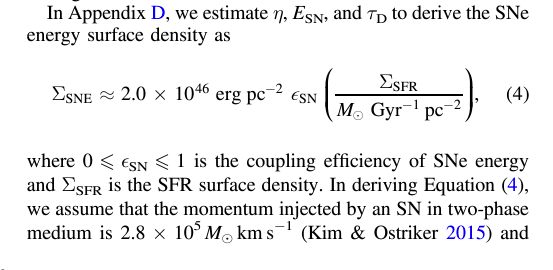

In [ ]:
# Kinetic energy density

fig, ax = plt.subplots(1, 1, figsize=(4.2, (4.4 / 6.4) * 4.2), sharex=True, sharey=True,
                       layout='constrained')

for this_gal in these_targets:

    energy_surfdens = 1.5 * (surfdens_dict[this_gal][1]) * (ew_profile_dict[this_gal][1])**2
    energy_surfdens = energy_surfdens.to(u.erg / (u.kpc**2))

    ax.semilogy(ew_profile_dict[this_gal][0].value, energy_surfdens.value,
                drawstyle='steps-mid',
                label=this_gal.upper())

    # Probably wrong...
    # diskheight = 100 * u.pc
    # tcross = diskheight / ew_profile_dict[this_gal][1]
    # energy_diss = 1.5 * (surfdens_dict[this_gal][1]) * (ew_profile_dict[this_gal][1])**3 / diskheight**2
    # energy_diss = energy_diss.to((u.erg / u.s) / u.cm**3)

    # ax.semilogy(ew_profile_dict[this_gal][0], energy_diss.value, drawstyle='steps-mid')

    # ax.text(ew_profile_dict[this_gal][0][15].value, energy_surfdens.value[15], this_gal.upper())

    sb.despine(ax=ax)


    # ax.text(0.975, 0.95, this_gal.upper(), transform=ax.transAxes,
    #         ha='right', va='top')

ax.set_ylim([1e41, 1e53])
ax.set_xlim([0, 8.2])

labelLines(ax.get_lines(), zorder=2.5, xvals=[5.3, 3.9, 6, 7.2][::-1], backgroundcolor='white', align=False, fontsize=10)

# Add a gray bar for a range of energy from CC SNe at different SF rates
# Equation 4 from Utomo+2019
sfr_high = 1e-3 * u.solMass / u.yr / u.kpc**2
sfr_low = 1e-5 * u.solMass / u.yr / u.kpc**2

def sn_energy_surfdens(sfr_surfdens, eff_sn=0.1):
    this_val = 2.0e46 * eff_sn * (sfr_surfdens.to(u.solMass / u.Gyr / u.pc**2).value) * u.erg / u.pc**2
    return this_val.to(u.erg / u.kpc**2)

print(np.log10(sn_energy_surfdens(sfr_high).value), np.log10(sn_energy_surfdens(sfr_low).value))

ax.fill_between([0, 8.2], sn_energy_surfdens(sfr_low).value, sn_energy_surfdens(sfr_high).value,
                color='gray', alpha=0.15)

ax.annotate(r"$\Sigma_{\rm SNE}$",
            xy=(1.5, 1e49),
            xytext=(0.5, 1e45),
            arrowprops=dict(facecolor='gray', shrink=0.05,
                            connectionstyle='arc3,rad=0.75',
                            linewidth=2),
            color='gray', fontsize=16)


ax.text(8.2, sn_energy_surfdens(sfr_high).value, r"$\Sigma_{\rm SFR} = 10^{-3}$",
        fontsize=11,
        va='center', ha='right')
# ax.text(8.2, sn_energy_surfdens(sfr_low).value, r"$10^{-5}$ (M$_\odot$ yr$^{-1}$ kpc$^{-2}$)",
ax.text(8.2, sn_energy_surfdens(sfr_low).value, r"$\Sigma_{\rm SFR} = 10^{-5}$",
        fontsize=11,
        va='center', ha='right')

ax.set_xlabel(r"$R_{\rm gal}$ (kpc)")
ax.set_ylabel(r"$\Sigma_{\rm E, HI}$ (erg kpc$^{-2}$)")

# fig.savefig("../figures/dwarfs_hi_energy_surfdens_profiles.pdf", bbox_inches='tight')

In [ ]:
(surfdens_dict[this_gal][1] * u.solMass / u.pc**2).unit